In [ ]:
!/usr/local/cuda/bin/nvcc —version
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git
%load_ext nvcc_plugin
!cuda-install-samples-11.2.sh ~ & cd /root/NVIDIA_CUDA-11.2_samples/

nvcc fatal   : Don't know what to do with '—version'
  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-1b8otdyy
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-1b8otdyy
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit 0a71d56e5dce3ff1f0dd2c47c29367629262f527
  Preparing metadata (setup.py) ... done
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.0.2-py3-none-any.whl size=4295 sha256=4f7983d95ff7ec28175684be71a0e9ef352170b31772378197ac256afcbc33bd
  Stored in directory: /tmp/pip-ephem-wheel-cache-tx_c1tru/wheels/a8/b9/18/23f8ef71ceb0f63297dd1903aedd067e6243a68ea756d6feea
Successfully built NVCCPlugin
created output directory at /content/src
Out bin /content/result.out
/bin/bash: line 1: cd: /root/NVIDIA_CUDA-11.2_samples/: No such file or directory
/bin/bash: line 1: cuda-install-samples-11.2.sh: command not found


In [ ]:
%%cu
#include "cuda_runtime.h"
#include "device_launch_parameters.h"

#include <stdio.h>
#include <malloc.h>
#include <stdio.h>
#include <stdlib.h>
#include <ctime>
#include <math.h>
#ifndef __CUDACC__
#define __CUDACC__
#endif

//Kernel function on GPU
__global__ void VecReduce(int* input, int* output) {
    extern __shared__ int shared[];
    int tx = threadIdx.x;
    int bx = blockIdx.x;
    int idx = blockIdx.x * blockDim.x + threadIdx.x;

    shared[tx] = input[idx];
    __syncthreads();

    int s = 1;
    while (s < blockDim.x) {
        int index = 2 * s * tx;
        if (index < blockDim.x) {
            shared[index] += shared[index + s];
        }
        __syncthreads();
        s *= 2;
    }

    if (tx == 0) output[bx] = shared[0];
}


int main()
{
    const int N = 1001001;
    int n = 1000;
    while (n < N) {
    //Задаём параметры грида
    int dimBlock = 512;
    int dimGrid = int((n + dimBlock) / dimBlock);
    //printf("\nGridDim := (%d)", dimGrid);
    //printf("\nBlockDim := (%d)", dimBlock);
    printf("\nVector dimension := %d\n", n);
    int n2b = n * sizeof(int);
    int sum_CPU = 0;

    // Выделение памяти на хосте
    int* vec = new int[n]; int* out_vec = new int[n];


    // Инициализация вектора
    for (int i = 0; i < n; i++) {
        vec[i] = 1;
    }
    printf("\nn2b := %d\n", n2b);

    int index = 0;
    // VecSum on CPU
    clock_t st_time = clock();
    while (index < n) {
        sum_CPU += vec[index];
        ++index;
    }
    clock_t end_time = clock();
    float CPU_time = ((double)end_time - st_time) / ((double)CLOCKS_PER_SEC);
    printf("\nThe CPU calculated for %.7f second(s)\n", CPU_time);


    // Выделение памяти на устройстве
    int* vecDev = NULL;
    cudaError_t cuerr = cudaMalloc((void**)&vecDev, n2b);
    int* out_vecDev = NULL;
    cuerr = cudaMalloc((void**)&out_vecDev, n2b); \
        // Создание обработчиков событий
        cudaEvent_t start, stop;
    float gpuTime = 0.0;
    cuerr = cudaEventCreate(&start);
    cuerr = cudaEventCreate(&stop);

    // Копирование данных с хоста на девайс
    cuerr = cudaMemcpy(vecDev, vec, n2b, cudaMemcpyHostToDevice);
    cuerr = cudaMemcpy(out_vecDev, out_vec, n2b, cudaMemcpyHostToDevice);


    // Установка точки старта
    cuerr = cudaEventRecord(start, 0);
    //Запуск ядра
    VecReduce << <dimGrid, dimBlock, dimBlock * sizeof(int) >> > (vecDev, out_vecDev);
    // Расчет времени
    // Накапливаем результат редукции в одну ячейку
    for (int i = 1; i < dimGrid; i++) {
        out_vec[0] += out_vec[i];
    }

    cuerr = cudaEventRecord(stop, 0);
    // Расчет времени
    // Синхронизация устройств
    cuerr = cudaDeviceSynchronize();

    //Количество нитей меньше количества элементов
    // Установка точки окончания
    cuerr = cudaEventRecord(stop, 0);

    // Копирование результата на хост
    cuerr = cudaMemcpy(out_vec, out_vecDev, n2b, cudaMemcpyDeviceToHost);

    cuerr = cudaEventElapsedTime(&gpuTime, start, stop);
    printf("The GPU calculated for %s: %.9f seconds\n", "kernel", gpuTime / 1000);
    printf("\nAcceleration on GPU := %.9f\n", CPU_time / (gpuTime / 1000));

    printf("\nVector sum on GPU := %d\n", out_vec[0]);

    cudaEventDestroy(start);
    cudaEventDestroy(stop);

    //Free GPU memory
    cudaFree(vecDev);
    cudaFree(out_vecDev);

    // Free CPU memory
    free(vec);
    free(out_vec);
        n += 50000;
    }
    return 0;

}


Vector dimension := 1000

n2b := 4000

The CPU calculated for 0.0000040 second(s)
The GPU calculated for kernel: 0.000031072 seconds

Acceleration on GPU := 0.128733262

Vector sum on GPU := 512

Vector dimension := 51000

n2b := 204000

The CPU calculated for 0.0001290 second(s)
The GPU calculated for kernel: 0.000023808 seconds

Acceleration on GPU := 5.418346405

Vector sum on GPU := 512

Vector dimension := 101000

n2b := 404000

The CPU calculated for 0.0002570 second(s)
The GPU calculated for kernel: 0.000035296 seconds

Acceleration on GPU := 7.281278133

Vector sum on GPU := 512

Vector dimension := 151000

n2b := 604000

The CPU calculated for 0.0003860 second(s)
The GPU calculated for kernel: 0.000037120 seconds

Acceleration on GPU := 10.398706436

Vector sum on GPU := 512

Vector dimension := 201000

n2b := 804000

The CPU calculated for 0.0005260 second(s)
The GPU calculated for kernel: 0.000050944 seconds

Acceleration on GPU := 10.325062752

Vector sum on GPU := 512

Ve

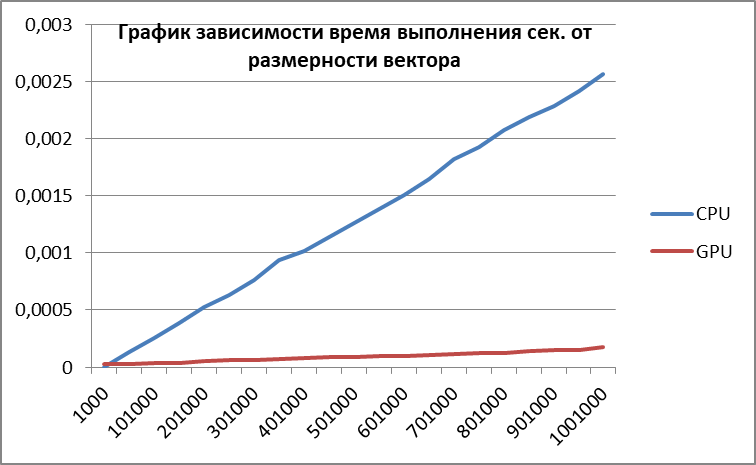

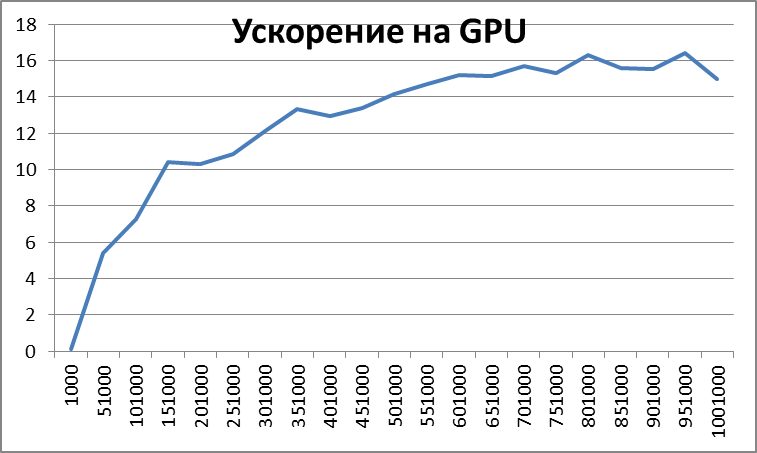